# 12-752: Data-Driven Building Energy Management
## Fall 2016, Carnegie Mellon University

## Assignment \#3

We will begin by unpickling the dataset containing the loadCurves that we had used in Assignment \#2. 

But first, as always, we will load most modules we will be using:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import datetime as dt
from sklearn import tree
from sklearn.model_selection import cross_val_score

%matplotlib inline

Now let's load the load curve dataset:

In [2]:
pkf = open('../../F16-12-752/lectures/data/loadCurves.pkl','rb')
data,loadCurves = pickle.load(pkf)
pkf.close()

Because the dataset we have is not sufficient to run an interesting regression task, we will also load a temperature dataset which shows 5-minute interval temperatures measured on the rooftop of Margaret Morrison at CMU.

You will find this dataset on BlackBoard. Download it and then load it into a new DataFrame called ```temperature```.

## Task \#1 [10%]

Create a new DataFrame with the temperature data, and set the index to be the Timestamp.

In [3]:
df_temp = pd.read_csv('../../F16-12-752/lectures/data/temperature.csv',parse_dates=['Timestamp'])
data.set_index('Time',inplace=True); df_temp.set_index('Timestamp',inplace=True)

Since the power consumption time series has a different sampling frequency, we need to resample the datasets so that they have the same frequency.

## Task \#2 [10%]:

Resample the original ```data``` and ```temperature``` DataFrames to one sample every five minutes. You can use any resampling technique, though an averaging method is probably the most appropriate here.

In [4]:
r_data = data.resample('5T').mean(); r_temp = df_temp.resample('5T').mean()

It may be easier to join both DataFrames into one. Let's do that.

## Task #3 [5%]:

Create a new DataFrame called ```alldata``` which is an inner join of the temperature and power datasets (i.e. the rows of ```aldata``` will be those with a timestamp that is present in both the electric power time series *and* the temperature time series).

For good measure, rename the columns of the resulting DataFrame to make them more descriptive and concise.

In [5]:
alldata = r_data.join(r_temp, how='inner')
alldata.rename(columns={"IW.Weather.Kpit56.Csv.Temp": "temp",'Value':'demand'},inplace=True)

Depending on how you answered the previous question, there is a chance that some of the entries of your DataFrame contain *null* values. There is a convenient method for DataFrames called ```isnull()``` which you can use to check this. 

## Task #4 [5%]:

Find out how many *null* values there are in the DataFrame. 

Using your method of choice (e.g., interpolation) fill those values so that they don't exist anymore and make a copy of the resulting DataFrame.

Comment on why these *null* values showed up.


In [6]:
print(alldata.isnull().sum())
print('The number of null-values in alldata is: ', np.sum(alldata.isnull().sum()))

demand       912
Hour         912
Weekday      912
DayOfYear    912
temp           0
dtype: int64
The number of null-values in alldata is:  3648


In [6]:
"""Applying linear interpolation to fill the null-values in the demand series."""

alldata['demand'].interpolate(inplace=True)
alldata['Hour'] = alldata.index.hour; alldata['Weekday'] = alldata.index.weekday; alldata['DayOfYear'] = alldata.index.dayofyear

In [ ]:
# alldata.iloc[23650:24010,:]

The null-values correspond to missing data from the power consumption meter. There are dates (i.e. Jan. 31, Feb. 1, Oct. 3, and late October and early November dates of 2014) that doesn't have information for several hours. Therefore, when resampling the dataset every five-minutes the algorothm doesn't find data to calculate the average consumption. The temperature meter does have all the information, so the dataframe doesn't have null value in the temperature column.

Now let's turn our attention to the task of fitting a model for regression. To start, let's visualize the time series and the relationship between them.

## Task \#5 [10%]:

Create a line plot with two separate vertical axes showing the Power and Temperature time series (e.g., one vertical axis for temperature and the other one for power, against a single time axis).

Then create a scatter plot for Power (y-axis) versus Temperature (x-axis).

What can you say about these plots and your data? How does this inform your decision to fit a regression model to predict power consumption?

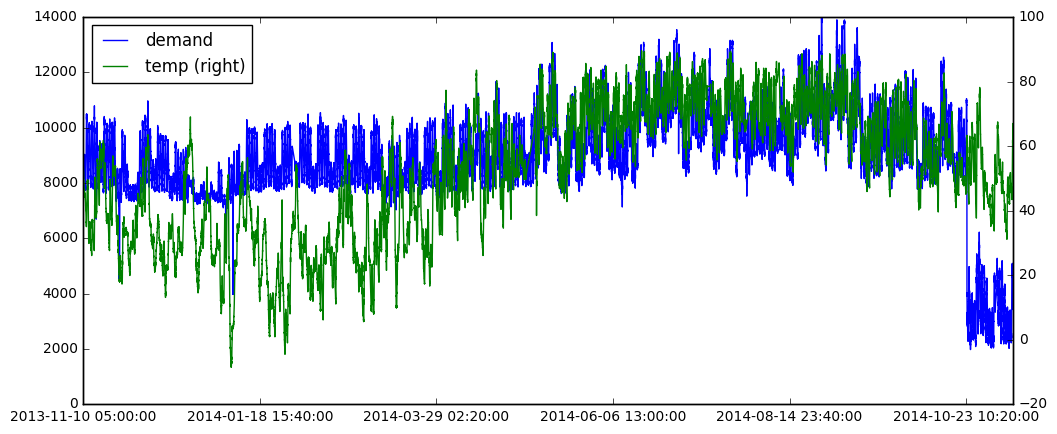

In [108]:
alldata.plot(x=alldata.index, y=['demand','temp'], secondary_y='temp', figsize=(12,5));

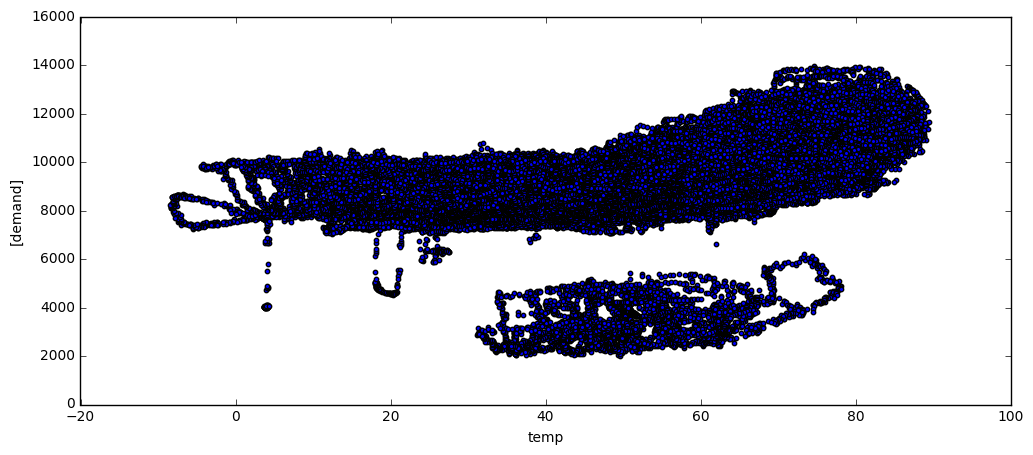

In [107]:
alldata.plot.scatter(x='temp', y=['demand'], secondary_y='temp', figsize=(12,5),s=10,c='b');

- Electricity demand shows hourly, weekly and monthly seasonality.
- Power consumption is positively correlated to temperature.
- There is a sag of consumption at the end period (from Oct. 23, 2014, after 5 p.m.) that creates a separate cluster in the scatter plot. Yet, this new cluster also relates fairly linear with respect to temperature.
- For temperatures below ~ 50°F, the relation between power and temperature is very subtle (almost flat). However, after this threshold, the slope between both variables increases rapidly.

# Task \#6 [40%]:

Separate the data into the features (X) and the response values (Y). Assume, to start, that the features are 'Hour','Weekday' and 'Temperature'; and that the response values are 'Power'.

**(a: 10%)** Fit a regression tree to the whole dataset. In other words, your fitted tree should be able to predict the power consumption for campus when given the hour of the day, day of the week and temperature for a specific time. Calculate the score of your fit (i.e., the R^2 of your predictions).

**(b: 20%)** Now, rearrange X and Y such that your response values are no longer scalars, but instead a vector of 1 hour periods (i.e., 12 continguous values at the 5-minute resolution). Using this arrangement, fit another regression tree (multi-output) 

**(c: 5%)** Using 10-fold cross-validation, figure out how to best optimize the performance (score) of your model on the dataset, by tweaking the way you are configuring the features X.

**(d: 5%)** Download the 2015 dataset for the campus power consumption (and temperature), and test the results of your trained model (the best one you found in the previous step on that dataset.

### Task 6-a

In [10]:
X = alldata.loc[:,['temp','Hour','Weekday']].as_matrix()[:100080]
y = alldata['demand'].as_matrix()[:100080]

clf = tree.DecisionTreeRegressor()
clf.fit(X, y)
clf.score(X,y)

0.99224493990954499

In [9]:
cross_val_score(clf, X, y, cv=10)

array([-1.58540995, -2.68452987, -1.80666973, -2.94733026, -3.20679493,
       -0.51450035,  0.17477633,  0.0548746 , -0.20085328, -0.50573849])

### Task 6-b

In [10]:
# Since the last hour of the dataset (2014-11-10 22:00:00) only has 50 minutes, we need to cut off this hour in order to reshape
# X and y.
XX = np.hstack([np.reshape(X[:-11,0],(-1,12)),np.reshape(X[:-11,1],(-1,12))[:,0][:,None],
                np.reshape(X[:-11,2],(-1,12))[:,0][:,None]])
yy = np.reshape(y[:-11],(-1,12))

clf = tree.DecisionTreeRegressor()
clf.fit(XX, yy)
clf.score(XX,yy)

1.0

### Task 6-c

In [11]:
cv_scores = cross_val_score(clf, XX, yy, cv=10)
print('Cross-validation scores:', cv_scores)
print('Average score:', np.mean(cv_scores))

Cross-validation scores: [ -1.62134155e+00  -3.44948731e+00  -3.00866621e+00  -4.86139650e+00
  -3.02560652e+00  -4.74831213e-01   4.49648633e-03  -2.66393225e-01
  -2.47715701e-01  -5.25959530e-01]
Average score: -1.7476901287


Even though the $R^2$ of the multi-ouput regressor is 1, it does not mean we have a good model. As matter of fact, this high $R^2$ most notably suggests overfitting. As a proof of that, when perfoming 10-fold crossvalidation, the resulting scores are far from acurate and even negative in the majority of cases. 

One way to attempt improving these results is by separating the data in two groups given tha remarkable drop in consumption in late October and early Novemeber 2014 (which probably correpond to faulty measuremetns). I am splitting the data in two sets:
- Set 1: Before 2014-10-23 17:00
- Set 2: After 2014-10-23 17:00  

In [7]:
""" Splitting the dataset"""
X1 = alldata.loc[:,['temp','Hour','Weekday']].as_matrix()[:100080]; y1 = alldata['demand'].as_matrix()[:100080]
X2 = alldata.loc[:,['temp','Hour','Weekday']].as_matrix()[100080:]; y2 = alldata['demand'].as_matrix()[100080:]

"""Set 1"""
XX1 = np.hstack([np.reshape(X1[:,0],(-1,12)),np.reshape(X1[:,1],(-1,12))[:,0][:,None],
                np.reshape(X1[:,2],(-1,12))[:,0][:,None]])
yy1 = np.reshape(y1,(-1,12))

clf1 = tree.DecisionTreeRegressor()
cv_scores = cross_val_score(clf1, XX1, yy1, cv=10)
print('Cross-validation scores in Set 1:', cv_scores)
print('Average score in Set 1:', np.mean(cv_scores))

"""Set 2"""
XX2 = np.hstack([np.reshape(X2[:-11,0],(-1,12)),np.reshape(X2[:-11,1],(-1,12))[:,0][:,None],
                np.reshape(X2[:-11,2],(-1,12))[:,0][:,None]])
yy2 = np.reshape(y2[:-11],(-1,12))

clf2 = tree.DecisionTreeRegressor()
cv_scores = cross_val_score(clf2, XX2, yy2, cv=10)
print('\nCross-validation scores in Set 2:', cv_scores)
print('Average score in Set 2:', np.mean(cv_scores))

Cross-validation scores in Set 1: [ 0.35101595 -1.14793731 -0.68668635  0.1157293   0.53613858  0.54370603
  0.44348086  0.22562326  0.51923845  0.57036015]
Average score in Set 1: 0.147066891328

Cross-validation scores in Set 2: [ 0.54617449  0.25544612  0.71149311  0.84604108  0.82628123  0.92684908
 -2.28844024  0.80647677  0.80091288  0.23012447]
Average score in Set 2: 0.36613589848


By splitting the dataset in two clusters, much better cross-validated scores can be achieved in both groups. This is becuase the sag in consumption at the end of the period skews the estimations for high temperatures. 

### Task 6-d

To further test the model, it is worth it to randomly separate the dataset 1 into a training set (90%) and a test set (10%). The following script performs this task several times and plots the histogram of the recorded scores.

In [29]:
scores = np.empty(1000)
split = np.int(yy1.shape[0]*9/10)
clf1 = tree.DecisionTreeRegressor()
for i in range(1000):
    P = np.random.permutation(yy1.shape[0])
    X_tr = XX1[P[:split]]; y_tr = yy1[P[:split]]
    X_te = XX1[P[split:]]; y_te = yy1[P[split:]]
    clf1.fit(X_tr,y_tr)
    scores[i] = clf1.score(X_te,y_te)
    pass

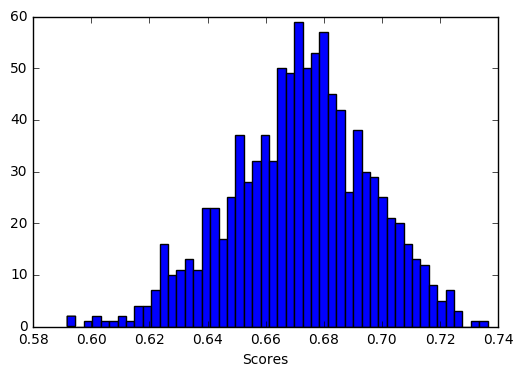

In [30]:
plt.hist(scores,bins=50);plt.xlabel('Scores');

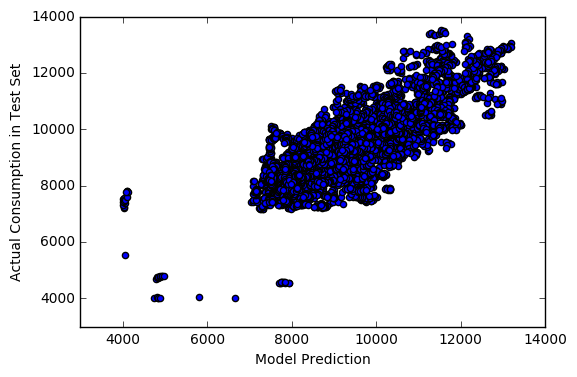

In [32]:
plt.scatter(np.reshape(clf1.predict(X_te),(-1,1)),np.reshape(y_te,(-1,1)));
plt.xlabel('Model Prediction'); plt.ylabel('Actual Consumption in Test Set'); plt.xlim([3000,14000]); plt.ylim([3000,14000]);

In [59]:
clf_best = tree.DecisionTreeRegressor()
clf_best.fit(XX1, yy1)
clf_best.score(XX1,yy1)

1.0